In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv, VecMonitor
from stable_baselines3.common.evaluation import evaluate_policy

In [2]:
from stochastic_proc.midprice import BrownianMidprice, HistoricalData, HistoricalMidprice, TrueMidprice
from stochastic_proc.arrivals import PoissonArrivals, HawkesArrivals
from stochastic_proc.dynamics import LimitOrderDynamics, DOGEUSDTDynamics
from envs.trading import TradingEnv
from agents.BaseAgent import AvellanedaStoikovAgent
from agents.GLFT import GLFTAgent
from rewards.RewardFunctions import PnLReward, InventoryQuadraticPenalty, SpreadRegularizer, SumReward
from utils.plot_single import run_and_log, plot_single_episode
from utils.plot_batch import simulate_batch, plot_batch
from utils.plot_lite import plot_trajectory, generate_results_table_and_hist, compare_poisson_vs_hawkes
from utils.calibration import hawkes_params
from utils.calibration import hawkes_params, glft_half_spreads
from envs.SB3tradingenv import SB3TradingVecEnv
from data.feed import *

In [3]:
def load_dogeusdt_data(filepath: str, sample_interval: int = 1) -> pd.DataFrame:
    """
    Load and preprocess DOGEUSDT L2 data
    
    Args:
        filepath: Path to the CSV file
        sample_interval: Take every nth row to reduce data size if needed
    """
    print(f"Loading DOGEUSDT data from {filepath}...")
    data = pd.read_csv(filepath)
    
    # Sample data if needed (for large datasets)
    if sample_interval > 1:
        data = data.iloc[::sample_interval].reset_index(drop=True)
    
    print(f"Loaded {len(data)} rows of DOGEUSDT data")
    print(f"Columns: {data.columns.tolist()}")
    
    # Calculate basic statistics
    if len(data) > 0:
        # Calculate mid prices for first few rows to understand data
        first_row = data.iloc[0]
        best_bid = first_row['bids[0].price']
        best_ask = first_row['asks[0].price']
        mid_price = (best_bid + best_ask) / 2
        spread = best_ask - best_bid
        
        print(f"First row - Best Bid: {best_bid}, Best Ask: {best_ask}")
        print(f"Mid Price: {mid_price:.6f}, Spread: {spread:.6f}")
        
        # Estimate tick size from data
        tick_size = estimate_tick_size(data)
        print(f"Estimated tick size: {tick_size:.6f}")
    
    return data

def estimate_tick_size(data: pd.DataFrame, sample_size: int = 1000) -> float:
    """Estimate tick size from the data"""
    prices = []
    
    # Sample some rows to estimate tick size
    sample_indices = np.linspace(0, len(data)-1, min(sample_size, len(data)), dtype=int)
    
    for idx in sample_indices:
        row = data.iloc[idx]
        # Add best bid/ask and a few levels
        for i in range(5):  # Check first 5 levels
            bid_col = f'bids[{i}].price'
            ask_col = f'asks[{i}].price'
            if bid_col in row:
                prices.extend([row[bid_col], row[ask_col]])
    
    if not prices:
        return 0.0001  # Default for DOGEUSDT
    
    prices = np.array(prices)
    unique_prices = np.unique(prices)
    diffs = np.diff(np.sort(unique_prices))
    
    # Most common difference is likely the tick size
    if len(diffs) > 0:
        tick_size = np.min(diffs[diffs > 0])
        return float(tick_size)
    else:
        return 0.0001

# data/utils.py (corrected volatility calculation)
def calculate_volatility(data: pd.DataFrame, window: int = 1000) -> float:
    """Calculate instantaneous volatility (per time step) from mid price returns"""
    mid_prices = []
    
    # Use a reasonable sample size for efficiency
    sample_size = min(len(data), 10000)
    for idx in range(sample_size):
        row = data.iloc[idx]
        best_bid = row['bids[0].price']
        best_ask = row['asks[0].price']
        mid_prices.append((best_bid + best_ask) / 2)
    
    mid_prices = np.array(mid_prices)
    
    # Remove any NaN values
    mid_prices = mid_prices[~np.isnan(mid_prices)]
    
    if len(mid_prices) < 2:
        return 0.001  # Reasonable default for DOGEUSDT
    
    # Calculate log returns (this gives us volatility per time step)
    returns = np.diff(np.log(mid_prices))
    
    # Remove extreme outliers
    returns_std = np.std(returns)
    returns = returns[np.abs(returns) < 5 * returns_std]
    
    if len(returns) < 2:
        return 0.001
    
    # Use recent data for volatility estimation
    if len(returns) > window:
        recent_returns = returns[-window:]
    else:
        recent_returns = returns
    
    # This is the instantaneous volatility (per time step)
    # For AS model, this should be the standard deviation of returns per time step
    instantaneous_volatility = np.std(recent_returns)
    
    print(f"Calculated instantaneous volatility (per time step): {instantaneous_volatility:.6f}")
    print(f"Sample size: {len(recent_returns)} returns")
    print(f"Mean return: {np.mean(recent_returns):.8f}")
    print(f"Return std: {instantaneous_volatility:.8f}")
    
    return float(instantaneous_volatility)

# Add this to debug volatility values
def debug_volatility_calculation(data: pd.DataFrame):
    """Debug function to understand volatility in the data"""
    mid_prices = []
    
    for idx in range(min(1000, len(data))):
        row = data.iloc[idx]
        best_bid = row['bids[0].price']
        best_ask = row['asks[0].price']
        mid_prices.append((best_bid + best_ask) / 2)
    
    mid_prices = np.array(mid_prices)
    returns = np.diff(np.log(mid_prices))
    
    print(f"Volatility analysis:")
    print(f"Number of returns: {len(returns)}")
    print(f"Return stats: min={returns.min():.8f}, max={returns.max():.8f}, std={returns.std():.8f}")
    print(f"95% of returns between: {np.percentile(returns, 2.5):.8f} and {np.percentile(returns, 97.5):.8f}")
    
    # What does this mean in price terms?
    typical_price = np.mean(mid_prices)
    typical_volatility = returns.std() * typical_price
    print(f"Typical mid price: {typical_price:.6f}")
    print(f"Typical price move per step: ±{typical_volatility:.6f}")
    
    return returns.std()

In [ ]:
def create_dogeusdt_env_single(data_path: str, episode_length: int = 1000, 
                             quote_size: float = 100.0, fill_method: str = "cross"):
    """Create single trajectory environment with DOGEUSDT data"""
    data = load_dogeusdt_data(data_path)
    feed = DOGEUSDTL2Feed(data)
    check = debug_volatility_calculation(data)
    # Use smaller episode length for testing
    actual_length = min(episode_length, len(data) - 1)
    
    # Calculate parameters from data
    volatility = calculate_volatility(data)
    tick_size = 0.0001  # DOGEUSDT tick size
    
    dyn = DOGEUSDTDynamics(
        feed=feed,
        tick_size=tick_size,
        quote_size=quote_size,
        max_depth=0.01,  # 1% max depth for DOGEUSDT
        num_traj=1,
        fill_method=fill_method
    )
    
    env = TradingEnv(
        dynamics=dyn,
        T=actual_length,  # Total time steps
        M=actual_length,   # Number of steps
        return_vectorized=False
    )
    
    # Store volatility for AS agent
    env.volatility = volatility
    env.tick_size = tick_size
    
    return env

def create_dogeusdt_env_batch(data_path: str, num_traj: int = 64, 
                            episode_length: int = 1000, quote_size: float = 100.0):
    """Create batch environment with DOGEUSDT data for RL training"""
    data = load_dogeusdt_data(data_path)
    feed = BatchDOGEUSDTFeed(data, num_traj=num_traj, episode_length=episode_length)
    
    
    volatility = calculate_volatility(data)
    tick_size = 0.0001
    
    dyn = DOGEUSDTDynamics(
        feed=feed,
        tick_size=tick_size,
        quote_size=quote_size,
        max_depth=0.01,
        num_traj=num_traj,
        fill_method="cross"
    )
    
    env = TradingEnv(
        dynamics=dyn,
        T=episode_length,
        M=episode_length,
        return_vectorized=True
    )
    
    env.volatility = volatility
    env.tick_size = tick_size
    
    return env

# Example usage
if __name__ == "__main__":
    # Single trajectory backtest
    env = create_dogeusdt_env_single("D:/Documents/CLS/thesis/MM_sandbox/binance_book_snapshot_25_2025-01-01_DOGEUSDT.csv", episode_length=1000)
    
    # Use AS agent with estimated volatility
    agent = AvellanedaStoikovAgent(env, gamma=0.1)
    
    obs, _ = env.reset()
    done = False
    pnls = []
    
    while not done:
        action = agent.get_action(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        pnls.append(reward)
        
        if len(pnls) % 100 == 0:
            print(f"Step {len(pnls)}, PnL: {sum(pnls):.4f}")
    
    print(f"Final PnL: {sum(pnls):.4f}")
    
    # For RL training
    # env = create_dogeusdt_env_batch("dogeusdt_l2.csv", num_traj=64, episode_length=1000)
    # vec_env = SB3TradingVecEnv(env)

# Avellaneda Stoikov

In [4]:
df= load_dogeusdt_data("D:/Documents/CLS/thesis/MM_sandbox/binance_book_snapshot_25_2025-01-01_DOGEUSDT.csv")
midprice = (df['asks[0].price'] + df['bids[0].price']) / 2
print(midprice, len(midprice))

Loading DOGEUSDT data from D:/Documents/CLS/thesis/MM_sandbox/binance_book_snapshot_25_2025-01-01_DOGEUSDT.csv...
Loaded 713815 rows of DOGEUSDT data
Columns: ['exchange', 'symbol', 'timestamp', 'local_timestamp', 'asks[0].price', 'asks[0].amount', 'bids[0].price', 'bids[0].amount', 'asks[1].price', 'asks[1].amount', 'bids[1].price', 'bids[1].amount', 'asks[2].price', 'asks[2].amount', 'bids[2].price', 'bids[2].amount', 'asks[3].price', 'asks[3].amount', 'bids[3].price', 'bids[3].amount', 'asks[4].price', 'asks[4].amount', 'bids[4].price', 'bids[4].amount', 'asks[5].price', 'asks[5].amount', 'bids[5].price', 'bids[5].amount', 'asks[6].price', 'asks[6].amount', 'bids[6].price', 'bids[6].amount', 'asks[7].price', 'asks[7].amount', 'bids[7].price', 'bids[7].amount', 'asks[8].price', 'asks[8].amount', 'bids[8].price', 'bids[8].amount', 'asks[9].price', 'asks[9].amount', 'bids[9].price', 'bids[9].amount', 'asks[10].price', 'asks[10].amount', 'bids[10].price', 'bids[10].amount', 'asks[11].pr

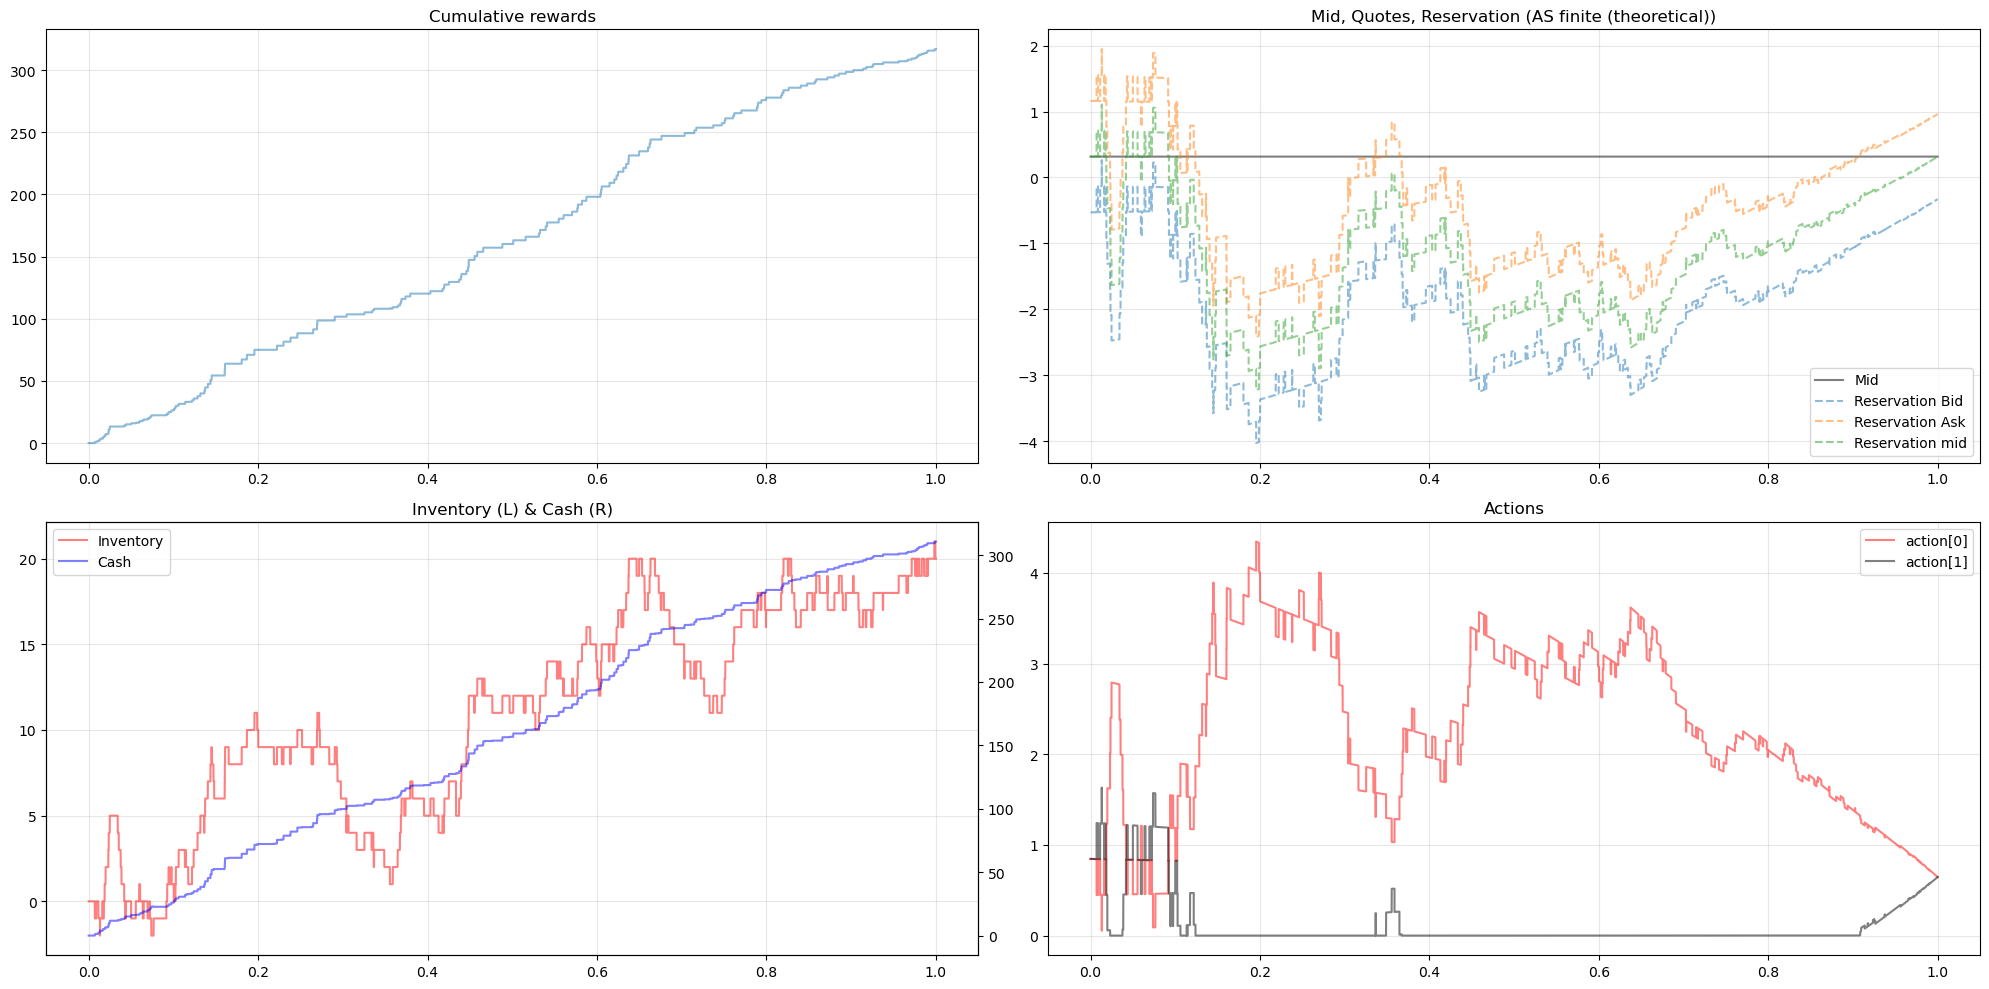

          Mean spread    Mean PnL    Std PnL Mean terminal inventory  \
Inventory    2.281021  315.483032  97.803032               -0.597656   

          Std terminal inventory  
Inventory               15.71245  


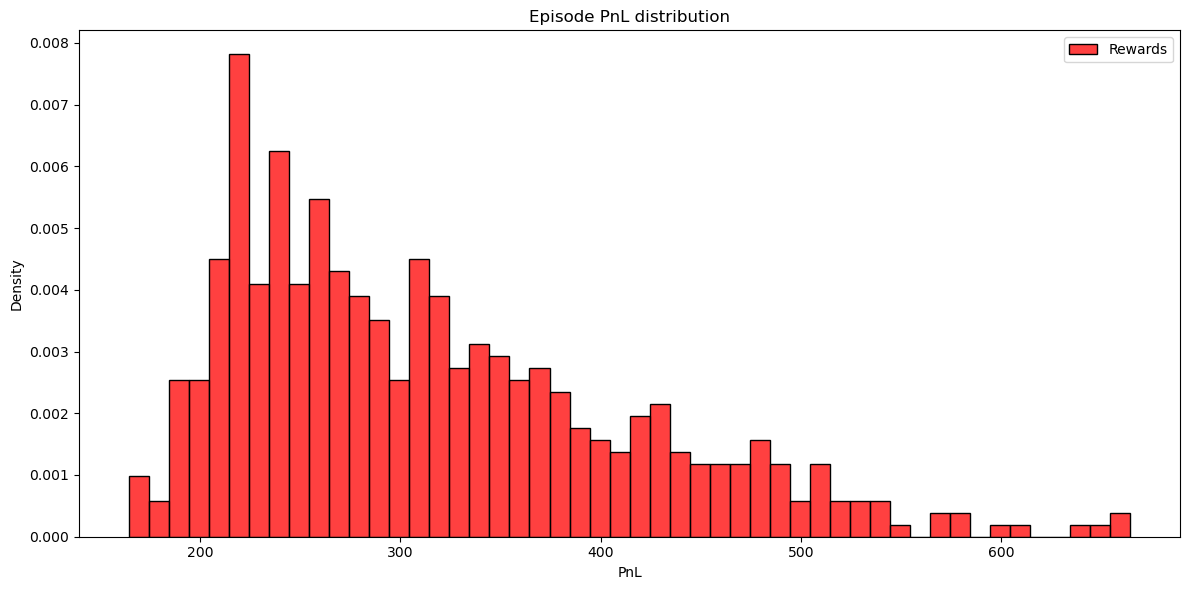

In [5]:
SEED, T, s0, sigma, A, k_fill, N = 42, 1.0, 100, 2.0, 140, 1.5, 1
M = len(midprice)
dt = T / M

# Make sure midprice has at least one element
if len(midprice) == 0:
    raise ValueError("midprice series is empty")

mid = TrueMidprice(midprice, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)

# Single-trajectory plotting (RL-style)
env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=False)
agent = AvellanedaStoikovAgent(env, gamma=0.1)
plot_trajectory(env, agent, show_reservation=True)

# Batch stats & PnL hist (vectorized episode)
mid = BrownianMidprice(s0, sigma, num_traj=512, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=512, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
env_vec = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=True)
agent = AvellanedaStoikovAgent(env_vec, gamma=0.1)
results, fig, totals = generate_results_table_and_hist(env_vec, agent)
print(results)

In [ ]:
SEED, T, M, s0, sigma, A, k_fill, N = 42, 1.0, 200, 100, 0.5, 7, 0.18, 1
dt = T / M
mid = BrownianMidprice(s0, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)

# Single-trajectory plotting (RL-style)
env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=False)
agent = AvellanedaStoikovAgent(env, gamma=0.1)
plot_trajectory(env, agent, show_reservation=False)

# Batch stats & PnL hist (vectorized episode)
mid = BrownianMidprice(s0, sigma, num_traj=512, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=512, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
env_vec = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=True)
agent = AvellanedaStoikovAgent(env_vec, gamma=0.1)
results, fig, totals = generate_results_table_and_hist(env_vec, agent)
print(results)

AS model using L2 DOGEUSDT order book data

In [ ]:
data = pd.read_csv("D:/Documents/CLS/thesis/MM_sandbox/binance_book_snapshot_25_2025-01-01_DOGEUSDT.csv")
mid_prices = (data['bids[0].price'] + data['asks[0].price']) / 2
timestamps = data['timestamp']
# Compute dt in seconds
dt = np.diff(timestamps).mean() / 1e6  # if timestamps are in microseconds

returns = np.diff(np.log(mid_prices))
sigma = np.std(returns) / np.sqrt(dt)  # annualized volatility
print(sigma)

In [ ]:
def create_historical_env(data_path: str, lam_bid: float, lam_ask: float, fill_k: float, max_depth: float = 20.0, sigma: float=2.0):
    data = pd.read_csv(data_path)
    mid_prices = (data['bids[0].price'] + data['asks[0].price']) / 2
    timestamps = data['timestamp']
    dt = np.diff(timestamps).mean() / 1e6  # in seconds

    T = len(mid_prices) * dt
    M = len(mid_prices)

    mid = HistoricalMidprice(mid_prices, num_traj=1, dt=dt, T=T)
    arr = PoissonArrivals(lam_bid, lam_ask, num_traj=1, dt=dt, T=T)
    dyn = LimitOrderDynamics(mid, arr, fill_k, max_depth)

    env = TradingEnv(dynamics=dyn, T=T, M=M, return_vectorized=False)
    return env
env = create_historical_env(data_path="D:/Documents/CLS/thesis/MM_sandbox/binance_book_snapshot_25_2025-01-01_DOGEUSDT.csv",
                            lam_bid=140, lam_ask=140, fill_k=5, max_depth=20)

agent = AvellanedaStoikovAgent(env, gamma=0.1, sigma=sigma)
plot_trajectory(env, agent, show_reservation=False)

In [ ]:
SEED, T, M, s0, sigma, A, k_fill, N = 42, 1.0, 200, 100.0, 2.0, 140, 5, 1

data = pd.read_csv("D:/Documents/CLS/thesis/MM_sandbox/binance_book_snapshot_25_2025-01-01_DOGEUSDT.csv")
mid_prices = (data['bids[0].price'] + data['asks[0].price']) / 2
timestamps = pd.to_datetime(data['timestamp'])
# Compute dt in seconds
dt = np.diff(timestamps).mean() / 1e6  # if timestamps are in microseconds

# If we want to use the entire data, then:
T = len(mid_prices) * dt
M = len(mid_prices)

mid = HistoricalMidprice(mid_prices, num_traj=1, dt=dt, T=T, sigma=sigma)
arr = PoissonArrivals(A, A, num_traj=1, dt=dt, T=T)
dyn = LimitOrderDynamics(mid, arr, k_fill, max_depth=20)

env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=False)
agent = AvellanedaStoikovAgent(env, gamma=0.1)
plot_trajectory(env, agent, show_reservation=False)

In [ ]:
SEED = 42
T, M = 1.0, 200
s0, sigma = 100.0, 2.0
A, k_fill = 140.0, 1.5
max_depth = 20.0
dt = T / M

K_TRAIN = 16  # number of parallel envs (8..32 is common)
K_EVAL  = 4

os.makedirs("./ckpt_best", exist_ok=True)
os.makedirs("./ckpt", exist_ok=True)
os.makedirs("./tb_mm", exist_ok=True)

In [ ]:
def make_env(seed_off=0):
    def _thunk():
        mid = BrownianMidprice(s0, sigma, num_traj=1, dt=dt, T=T, seed=SEED + seed_off)
        arr = PoissonArrivals(A, A, num_traj=1, dt=dt, T=T, seed=SEED + seed_off)
        dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=max_depth)

        env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED + seed_off, return_vectorized=False)
        return env
    return _thunk

In [ ]:
# train
vec_train = DummyVecEnv([make_env(i) for i in range(K_TRAIN)])
vec_train = VecMonitor(vec_train)                                  
vec_train = VecNormalize(vec_train, norm_obs=True, norm_reward=False, clip_obs=10.0)

# eval
vec_eval = DummyVecEnv([make_env(10_000 + i) for i in range(K_EVAL)])
vec_eval = VecMonitor(vec_eval)                                    
vec_eval = VecNormalize(vec_eval, norm_obs=True, norm_reward=False, clip_obs=10.0)
vec_eval.obs_rms = vec_train.obs_rms

PPO policy

In [ ]:
model = PPO(
    "MlpPolicy",
    vec_train,
    n_steps=M,                               
    batch_size=min(4096, K_TRAIN * M),       
    learning_rate=3e-4,
    n_epochs=10,
    gamma=1.0,                              
    gae_lambda=0.95,
    clip_range=0.2,
    vf_coef=0.5,
    ent_coef=0.0,
    seed=SEED,
    policy_kwargs=dict(net_arch=[128, 128]),
    tensorboard_log="./tb_mm/",
    device="auto",
)

eval_cb = EvalCallback(
    vec_eval,
    best_model_save_path="./ckpt_best/",
    log_path="./eval_logs/",
    eval_freq=(10_000 // M) * M,
    n_eval_episodes=5,
    deterministic=True,
)
ckpt_cb = CheckpointCallback(save_freq=50_000, save_path="./ckpt/", name_prefix="ppo_mm")

total_timesteps = 1_000_000
model.learn(total_timesteps=total_timesteps, callback=[eval_cb, ckpt_cb])


In [ ]:
seed_plot = 123

vec_plot = DummyVecEnv([make_env(seed_plot)])
vec_plot = VecMonitor(vec_plot)
vec_plot = VecNormalize(vec_plot, norm_obs=True, norm_reward=False, clip_obs=10.0)
vec_plot.obs_rms = vec_train.obs_rms

raw_env = make_env(seed_plot)()
obs_norm = vec_plot.reset()     # (1, obs_dim)
obs_raw, _ = raw_env.reset(seed=seed_plot)

In [ ]:
# assuming obs layout: [price, inventory, time_idx, cash]
ASSET_PRICE, INVENTORY, TIMEIDX, CASH = 0, 1, 2, 3

S_pre, S_post = [], []
Q, C, T_idx = [], [], []
HB, HA = [], []
R = []

done = False
while not done:
    
    action, _ = model.predict(obs_norm, deterministic=True)

    
    obs_norm, r_vec, dones_vec, infos = vec_plot.step(action)
    done = bool(dones_vec[0])

    
    next_obs_raw, r_raw, term_raw, trunc_raw, info_raw = raw_env.step(action[0])

    
    S_pre.append(obs_raw[ASSET_PRICE])
    Q.append(obs_raw[INVENTORY])
    T_idx.append(obs_raw[TIMEIDX])
    C.append(obs_raw[CASH])
    HB.append(action[0, 0])
    HA.append(action[0, 1])
    R.append(float(r_raw))
    S_post.append(next_obs_raw[ASSET_PRICE])

    obs_raw = next_obs_raw  

S_pre  = np.asarray(S_pre)           
S_post = np.asarray(S_post)               
Q      = np.asarray(Q)
C      = np.asarray(C)
T_idx  = np.asarray(T_idx)
HB     = np.asarray(HB)
HA     = np.asarray(HA)
R      = np.asarray(R)

timestamps = T_idx * (T / M)
cum_R = np.cumsum(R)
bid_quoted = S_post - HB
ask_quoted = S_post + HA

print(f"Episode PnL: {cum_R[-1]:.3f}")


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 10))
ax3b = ax3.twinx()

# (1) Cumulative PnL
ax1.plot(timestamps, cum_R, lw=1.8)
ax1.set_title("Cumulative Reward (PnL)")
ax1.set_xlabel("time"); ax1.set_ylabel("PnL"); ax1.grid(alpha=0.3)

# (2) Mid & Quotes
ax2.plot(timestamps, S_pre, color="k", lw=1.5, label="Mid Price")
ax2.plot(timestamps, bid_quoted, color="tab:blue",  alpha=0.9, label="Bid Price")
ax2.plot(timestamps, ask_quoted, color="tab:orange", alpha=0.9, label="Ask Price")
ax2.set_title("Mid & PPO Quotes")
ax2.set_xlabel("time"); ax2.set_ylabel("price")
ax2.grid(alpha=0.3); ax2.legend(loc="best")

# (3) Inventory & Cash
ax3.plot(timestamps, Q, color="tab:red",   label="Inventory")
ax3b.plot(timestamps, C, color="tab:green", label="Cash")
ax3.set_title("Inventory & Cash")
ax3.set_xlabel("time"); ax3.set_ylabel("inventory"); ax3b.set_ylabel("cash")
ax3.grid(alpha=0.3)
h1,l1 = ax3.get_legend_handles_labels()
h2,l2 = ax3b.get_legend_handles_labels()
ax3.legend(h1+h2, l1+l2, loc="best")

# (4) Actions (half-spreads)
ax4.plot(timestamps, HB, label="Bid half-spread")
ax4.plot(timestamps, HA, label="Ask half-spread")
ax4.set_title("PPO Actions"); ax4.set_xlabel("time"); ax4.set_ylabel("half-spread")
ax4.legend(loc="best"); ax4.grid(alpha=0.3)

plt.tight_layout(); plt.show()

Infinite horizon

In [ ]:
SEED, T, M, s0, sigma, A, k_fill, N = 42, 1.0, 200, 100.0, 2.0, 140.0, 1.5, 1
dt = T / M
mid = BrownianMidprice(s0, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)

# Single-trajectory plotting (RL-style)
env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=False)
agent_inf = AvellanedaStoikovAgent(env, gamma=0.8, mode="infinite", q_max=5)
plot_trajectory(env, agent_inf, show_reservation=False)

# Batch stats & PnL hist (vectorized episode)
mid = BrownianMidprice(s0, sigma, num_traj=512, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=512, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
env_vec = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=True)
agent_inf = AvellanedaStoikovAgent(env_vec, gamma=0.8, mode="infinite", q_max=5)
results, fig, totals = generate_results_table_and_hist(env_vec, agent_inf)
print(results)

Hawkes distribution

In [ ]:
SEED, T, M, s0, sigma, A, k_fill, N = 42, 1.0, 200, 100.0, 2.0, 140.0, 1.5, 1
dt = T / M
mu, kappa, jump = hawkes_params(dt=dt, p_target=0.30, eta=0.85, memory_steps=10)

mid = BrownianMidprice(s0, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
arr = HawkesArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED, kappa=kappa, jump=jump)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)

# Single-trajectory plotting (RL-style)
env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=False)
agent = AvellanedaStoikovAgent(env, gamma=0.1)
plot_trajectory(env, agent, show_reservation=False)

# Batch stats & PnL hist (vectorized episode)
mid = BrownianMidprice(s0, sigma, num_traj=512, dt=dt, T=T, seed=SEED)
arr = HawkesArrivals(A, A, num_traj=N, dt=dt, T=T, kappa=kappa, jump=jump, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
env_vec = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=True)
agent = AvellanedaStoikovAgent(env_vec, gamma=0.1)
results, fig, totals = generate_results_table_and_hist(env_vec, agent)
print(results)

GLFT

In [ ]:
SEED, T, M, s0, sigma, A, k_fill, N, k = 42, 1.0, 200, 100.0, 2.0, 140.0, 1.5, 1, 0.5
dt = T / M
mid = BrownianMidprice(s0, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
    
# Single-trajectory plotting (RL-style)
env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=False)
agent = GLFTAgent(env, gamma=0.1, A=A, k=k, xi=1.0, tick=1.0)
plot_trajectory(env, agent, show_reservation=False)

# Batch stats & PnL hist (vectorized episode)
mid = BrownianMidprice(s0, sigma, num_traj=512, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=512, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
env_vec = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=True)
GLFT_agent = GLFTAgent(env, gamma=0.1, A=A, k=k, xi=1.0, tick=1.0)
results, fig, totals = generate_results_table_and_hist(env_vec, GLFT_agent)
print(results)

Plotting difference between Poisson distribution and Hawkes distribution

In [ ]:
compare_poisson_vs_hawkes(dt=0.01, steps=200, seed=42,
                          lam_buy=30, lam_sell=30,
                          mu=10, kappa=60, jump=40)

In [ ]:
# auto-import path or pass your classes explicitly
from stochastic_proc.arrivals import PoissonArrivals, HawkesArrivals

compare_poisson_vs_hawkes(
    dt=0.01, steps=200, seed=42,
    lam_buy=30, lam_sell=30,
    mu=10, kappa=60, jump=40,
    poisson_cls=PoissonArrivals,
    hawkes_cls=HawkesArrivals,
)


In [ ]:
import inspect
from stochastic_proc.arrivals import PoissonArrivals, HawkesArrivals
print("PoissonArrivals:", inspect.signature(PoissonArrivals.__init__))
print("HawkesArrivals :", inspect.signature(HawkesArrivals.__init__))
